# LLaDA Inference Profiling on HumanEval

This notebook runs inference on the LLaDA model using the HumanEval dataset and collects statistics for profiling.

## Import

In [ ]:
import os
import subprocess
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

os.environ['HF_HOME'] = '/root/LLaDA/hf_models/'
from transformers import AutoTokenizer, AutoModel

from generate import generate

from my_utils.run_inference import (
    ActivationProfiler,
    run_inference
)
from my_utils.inference_analysis import (
    collect_token_evolution,
    get_token_coverage_stats,
    analyze_token_transitions
)
from my_utils.visualize import (
    plot_latency_distribution,
    plot_step_breakdown,
    plot_token_evolution,
    enhanced_cosine_similarity_with_full_evolution
)


### Load Model and Dataset

In [ ]:

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load Model and Tokenizer
model_id = 'GSAI-ML/LLaDA-8B-Instruct'
cache_path = '/root/LLaDA/hf_models/hub'

tensor_dir = '/root/autodl-tmp/profiling_results'
save_dir = '/root/cosine_similarity_plots'

print(f"Loading model: {model_id}")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, cache_dir=cache_path, local_files_only=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.bfloat16, cache_dir=cache_path, local_files_only=True).to(device).eval()

# Ensure padding side is left for generation
if tokenizer.padding_side != 'left':
    tokenizer.padding_side = 'left'

print(model)

In [ ]:
# Load HumanEval Dataset
print("Loading HumanEval dataset...")
dataset_path = '/root/LLaDA/hf_models/datasets/openai_humaneval'
ds = load_dataset(path=dataset_path, split="test")
print(f"Loaded {len(ds)} problems.")

# Display a sample
print("\nSample Problem:")
print(ds[0]['prompt'])

## Run Model Inference and Collect Statistics

In [ ]:
# Run Inference on a Subset
num_samples = 1
results = []
all_step_details = []

# Initialize Profiler
# profiler = ActivationProfiler(model, target_layers=['ff_out'], save_dir=tensor_dir)
profiler = ActivationProfiler(model, target_layers=['q_proj', 'k_proj', 'v_proj', 'attn_out'], save_dir=tensor_dir)

# Ensure hooks are cleared initially
profiler.clear()

print(f"Running inference on first {num_samples} samples...")

for i in range(num_samples):
    problem = ds[i]
    prompt = problem['prompt']
    task_id = problem['task_id']
    
    print(f"Processing {task_id}...")

	# Register hooks for this run
    profiler.register_hooks()

    try:
        # Using parameters from chat.py/generate.py examples
        output, duration, step_details = run_inference(
            model=model, 
            tokenizer=tokenizer, 
            prompt_text=prompt, 
            steps=128, 
            gen_length=128, 
            block_length=32,
            profiler=profiler
        )
        
        results.append({
            "task_id": task_id,
            "wall_time": duration,
            "output_length": len(output),
            "output": output
        })
        
		# Add task_id to each step detail
        for d in step_details:
            d['task_id'] = task_id
        all_step_details.extend(step_details)
        print(f"  Time: {duration:.4f}s")
    except Exception as e:
        print(f"  Error: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # Remove hooks to free memory and prevent crashes in subsequent runs
        profiler.clear()

profiler.clear() # Remove hooks after done

df_results = pd.DataFrame(results)
df_steps = pd.DataFrame(all_step_details)

## Statistics Analysis and Visualization

### Latency Analysis

In [ ]:
plot_latency_distribution(df_results)

### Token State Evolution

This section analyzes how token states evolve during the denoising process by examining the saved token state data.

#### Token Evolution Visualization

Analyzing token state evolution...
Loaded token states for 128 steps
Sequence length: 267


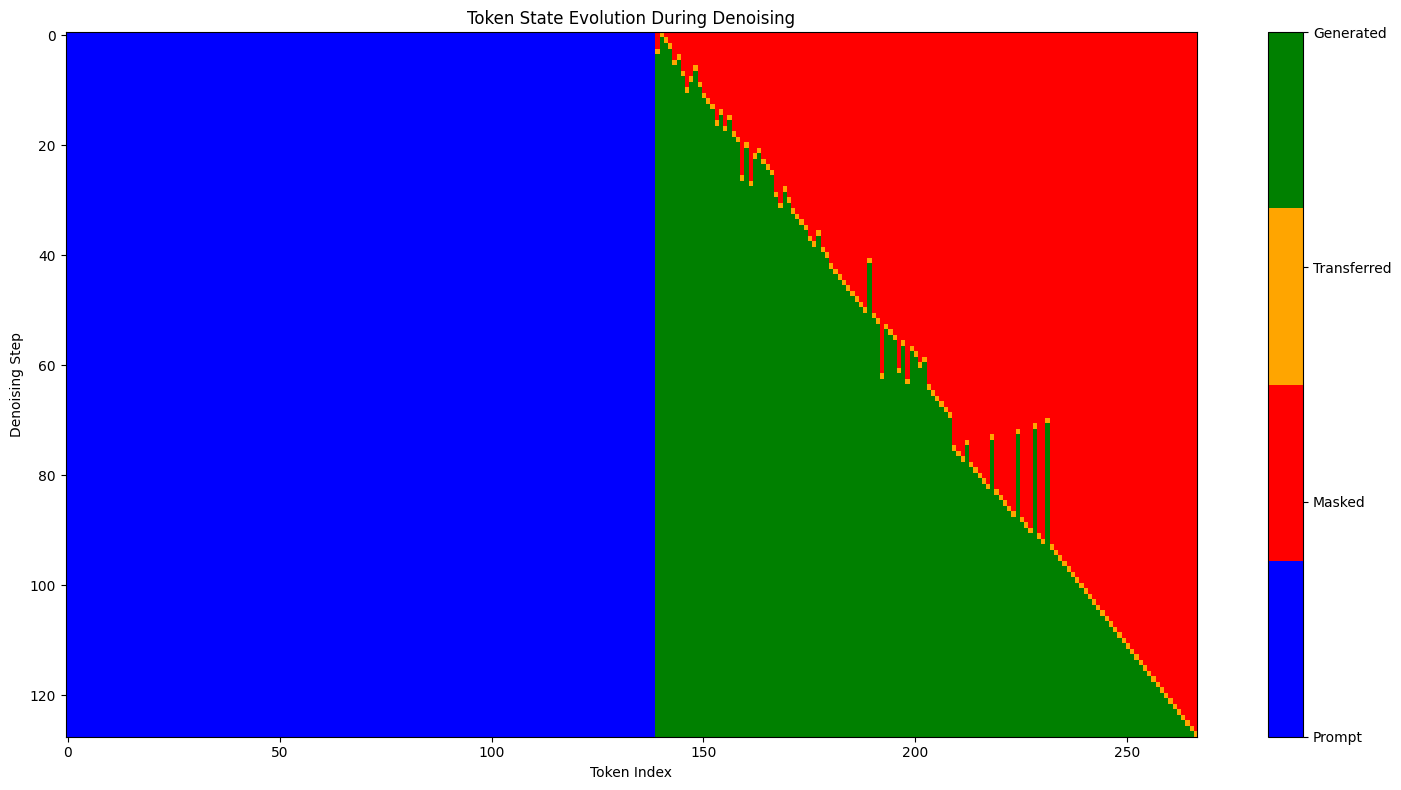

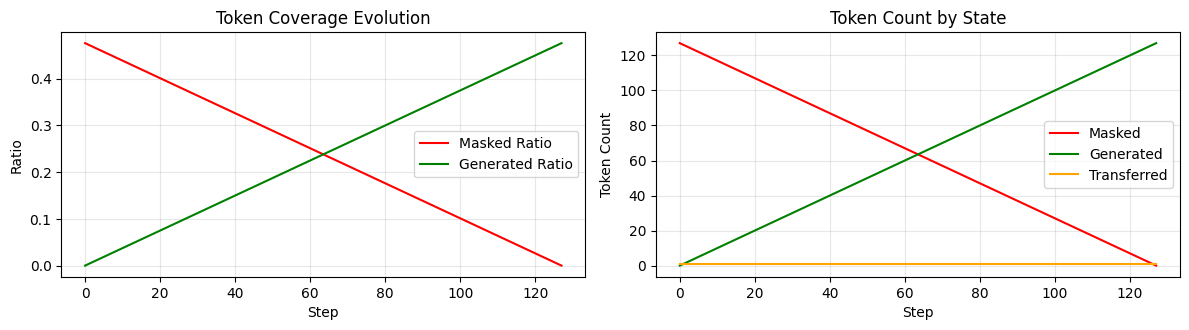

In [6]:
# Collect token evolution data
print("Analyzing token state evolution...")
df_token_evolution = collect_token_evolution(tensor_dir)

if not df_token_evolution.empty:
    print(f"Loaded token states for {len(df_token_evolution['step'].unique())} steps")
    print(f"Sequence length: {df_token_evolution['token_idx'].max() + 1}")
    
    # Get coverage statistics
    df_coverage = get_token_coverage_stats(df_token_evolution)
    
    plot_token_evolution(df_token_evolution=df_token_evolution, df_coverage=df_coverage)

else:
    print("No token state data found. Make sure profiling was run with token state saving enabled.")

#### Detailed Token Transition Analysis

In [ ]:
if not df_token_evolution.empty:
    # Analyze token transitions
    df_transitions = analyze_token_transitions(df_token_evolution)
    
    if not df_transitions.empty:
        print(f"\nFound {len(df_transitions)} token state transitions")
        
        # Transition frequency analysis
        transition_counts = df_transitions.groupby(['from_state', 'to_state']).size().reset_index(name='count')
        
        plt.figure(figsize=(10, 6))
        
        # Create transition matrix for heatmap
        states = ['prompt', 'masked', 'transferred', 'generated']
        transition_matrix = pd.pivot_table(transition_counts, 
                                         index='from_state', 
                                         columns='to_state', 
                                         values='count', 
                                         fill_value=0)
        
        # Reindex to ensure all states are included
        transition_matrix = transition_matrix.reindex(index=states, columns=states, fill_value=0)
        
        sns.heatmap(transition_matrix, annot=True, cmap='Blues')
        plt.title('Token State Transition Matrix')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.tight_layout()
        plt.show()
        
        # Transition timing analysis
        plt.figure(figsize=(12, 4))
        
        for transition_type in transition_counts[['from_state', 'to_state']].apply(
            lambda x: f"{x['from_state']} → {x['to_state']}", axis=1).unique():
            
            from_state, to_state = transition_type.split(' → ')
            transition_data = df_transitions[
                (df_transitions['from_state'] == from_state) & 
                (df_transitions['to_state'] == to_state)
            ]
            
            if len(transition_data) > 0:
                step_counts = transition_data['step'].value_counts().sort_index()
                plt.plot(step_counts.index, step_counts.values, 
                        marker='o', label=transition_type, alpha=0.7)
        
        plt.xlabel('Step')
        plt.ylabel('Number of Transitions')
        plt.title('Token State Transitions Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nTransition Summary:")
        print(transition_counts.to_string(index=False))
    else:
        print("No state transitions detected.")


#### Token-Level Detailed Analysis


In [ ]:
if not df_token_evolution.empty:
    # Analyze specific token ranges
    seq_len = df_token_evolution['token_idx'].max() + 1
    prompt_len = df_token_evolution[df_token_evolution['state'] == 'prompt']['token_idx'].max() + 1
    gen_len = seq_len - prompt_len
    
    print(f"\nSequence Analysis:")
    print(f"Total sequence length: {seq_len}")
    print(f"Prompt length: {prompt_len}")
    print(f"Generation length: {gen_len}")
    
    # Focus on generation region
    gen_tokens = df_token_evolution[df_token_evolution['token_idx'] >= prompt_len].copy()
    
    if not gen_tokens.empty:
        plt.figure(figsize=(15, 8))
        
        # Generation region heatmap
        gen_steps = sorted(gen_tokens['step'].unique())
        gen_token_indices = sorted(gen_tokens['token_idx'].unique())
        
        state_matrix_gen = np.full((len(gen_steps), len(gen_token_indices)), -1)
        
        for i, step in enumerate(gen_steps):
            step_data = gen_tokens[gen_tokens['step'] == step]
            for _, row in step_data.iterrows():
                j = gen_token_indices.index(row['token_idx'])
                state_matrix_gen[i, j] = state_map[row['state']]
        
        plt.imshow(state_matrix_gen, cmap=cmap, aspect='auto', interpolation='nearest')
        plt.xlabel('Generation Token Index')
        plt.ylabel('Denoising Step')
        plt.title('Token State Evolution in Generation Region')
        
        # Adjust x-axis labels to show actual token indices
        n_ticks = min(10, len(gen_token_indices))
        tick_indices = np.linspace(0, len(gen_token_indices)-1, n_ticks, dtype=int)
        plt.xticks(tick_indices, [gen_token_indices[i] for i in tick_indices])
        
        cbar = plt.colorbar(ticks=[0, 1, 2, 3])
        cbar.set_ticklabels(['Prompt', 'Masked', 'Transferred', 'Generated'])
        
        plt.tight_layout()
        plt.show()
        
        # Block boundary analysis
        block_transitions = gen_tokens.groupby(['step', 'block_idx']).size().reset_index(name='count')
        
        plt.figure(figsize=(12, 4))
        for block_idx in sorted(block_transitions['block_idx'].unique()):
            block_data = df_coverage[df_coverage['block_idx'] == block_idx]
            plt.axvspan(block_data['step'].min(), block_data['step'].max(), 
                       alpha=0.3, label=f'Block {block_idx}')
        
        plt.plot(df_coverage['step'], df_coverage['generated_tokens'], 'g-', linewidth=2)
        plt.xlabel('Step')
        plt.ylabel('Generated Tokens')
        plt.title('Token Generation Progress with Block Boundaries')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

print("Token state evolution analysis complete!")

### Tensor Distribution

#### Function Definitions

In [ ]:
# =========================
# Tensor loader utilities (saved to disk during inference)
# =========================
import glob, re

_layer_re = re.compile(
    r".*_(?:layers|transformer_blocks)_(\d+).*_(q_proj|k_proj|v_proj|attn_out|ff_proj|up_proj|ff_out)\.pt$"
)
tensor_dir = '/root/autodl-tmp/profiling_results'


def load_step_tensors(base_dir, step, selector_substrings):
    """
    Returns {layer_file: tensor} for files containing any selector substring.
    selector_substrings: list[str], e.g., ['q_proj', 'k_proj'].
    """
    step_dir = os.path.join(base_dir, f"step_{step}")
    tensors = {}
    if not os.path.isdir(step_dir):
        return tensors
    for f in glob.glob(os.path.join(step_dir, "*.pt")):
        base = os.path.basename(f)
        if any(s in base for s in selector_substrings):
            tensors[base] = torch.load(f, map_location="cpu")
    return tensors


def parse_layer_and_kind(layer_file_basename):
    m = _layer_re.match(layer_file_basename)
    if m:
        return int(m.group(1)), m.group(2)
    for k in ['q_proj','k_proj','v_proj','attn_out','ff_proj','up_proj','ff_out']:
        if k in layer_file_basename:
            return None, k
    return None, None


def reduce_stat(t, how="mean_abs", sample=None):
    """
    Reduce a tensor [batch, seq, hidden] to a scalar.
    how: 'mean_abs' | 'max_abs' | 'std' | 'l2'
    sample: dict to subsample dims, e.g., {'seq': 256, 'hidden': 512}
    """
    x = t
    # optional subsample to reduce memory/plot time
    if sample:
        b, s, h = x.shape
        if 'seq' in sample:
            x = x[:, torch.linspace(0, s-1, steps=min(sample['seq'], s), dtype=torch.long), :]
        if 'hidden' in sample:
            x = x[:, :, torch.linspace(0, h-1, steps=min(sample['hidden'], h), dtype=torch.long)]
    x = x.float()
    if how == "mean_abs":
        return x.abs().mean().item()
    if how == "max_abs":
        return x.abs().amax().item()
    if how == "std":
        return x.std().item()
    if how == "l2":
        return x.pow(2).mean().sqrt().item()
    raise ValueError(how)


def collect_series(base_dir, selectors=('q_proj','k_proj'), how="mean_abs", sample=None, steps=None):
    """
    Scan steps->layers and compute a scalar stat per (step, layer, kind).
    Returns DataFrame columns: step, layer_idx, kind, value
    """
    rows = []
    # infer steps if not provided
    if steps is None:
        step_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("step_")],
                           key=lambda x: int(x.split('_')[1]))
        steps = [int(d.split('_')[1]) for d in step_dirs]
    for step in steps:
        tensors = load_step_tensors(base_dir, step, selectors)
        for name, t in tensors.items():
            layer_idx, kind = parse_layer_and_kind(name)
            if kind is None: 
                continue
            val = reduce_stat(t, how=how, sample=sample)
            rows.append({"step": step, "layer_idx": layer_idx, "kind": kind, "value": val, "name": name})
    return pd.DataFrame(rows)


def flatten_activation(t, mode="batch_seq_mean"):
    x = t.float()
    if mode == "batch_seq_mean":
        return x.mean(dim=(0, 1))                        # [hidden]
    if mode == "batch_mean":
        return x.mean(dim=0).reshape(-1, x.size(-1))     # [seq, hidden]
    if mode == "none":
        return x.reshape(-1, x.size(-1))                 # [tokens, hidden]
    raise ValueError(mode)


def _token_matrix(x):
    x = x.float()
    if x.ndim == 2:
        return x
    if x.ndim == 3:
        return x.view(-1, x.size(-1))
    raise ValueError(f"Unsupported tensor shape {tuple(x.shape)} for token-wise mode")


def cosine_similarity_tensors(t_a, t_b, mode="batch_seq_mean"):
    if mode == "token-wise":
        a = _token_matrix(t_a)
        b = _token_matrix(t_b)
        sims = F.cosine_similarity(a, b, dim=-1)
        return sims.cpu().numpy()
    elif mode == 'batch_seq_mean':
        a = flatten_activation(t_a, 'batch_seq_mean')
        b = flatten_activation(t_b, 'batch_seq_mean')
        if a.ndim == 1:
            return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()
        sims = F.cosine_similarity(a, b, dim=-1)
        return sims.mean().item()
    elif mode == 'batch_mean':
        a = flatten_activation(t_a, 'batch_mean')          # [seq, hidden]
        b = flatten_activation(t_b, 'batch_mean')
        sims = F.cosine_similarity(a, b, dim=-1)
        return sims.mean().item()
    else:
        raise ValueError(mode)


def expand_tokenwise_similarity(df_sim):
    rows = []
    for _, row in df_sim.iterrows():
        sims = row["similarity"]
        if isinstance(sims, np.ndarray) and row["layer_idx"] is not None:
            for token_idx, val in enumerate(sims):
                rows.append({
                    "step_pair": f"{row['step_a']}→{row['step_b']}",
                    "layer_idx": row["layer_idx"],
                    "name": row["name"],
                    "token_idx": token_idx,
                    "token_similarity": float(val),
                })
    return pd.DataFrame(rows)


def collect_similarity_for_pairs(base_dir, step_pairs, selector="attn_out", tensor_names=None, mode="batch_seq_mean"):
    rows = []
    for step_a, step_b in step_pairs:
        tensors_a = load_step_tensors(base_dir, step_a, [selector])
        tensors_b = load_step_tensors(base_dir, step_b, [selector])
        candidates = tensors_a.keys() if not tensor_names else [
            name for name in tensors_a if any(tag in name for tag in tensor_names)
        ]
        for name in candidates:
            if name not in tensors_b:
                continue
            layer_idx, kind = parse_layer_and_kind(name)
            sim = cosine_similarity_tensors(tensors_a[name], tensors_b[name], mode=mode)
            rows.append({
                "step_a": step_a,
                "step_b": step_b,
                "layer_idx": layer_idx,
                "kind": kind,
                "name": name,
                "similarity": sim,
            })
    return pd.DataFrame(rows)

#### Run Analysis

In [ ]:
# Heatmap of mean_abs over (steps x layers) for q_proj
df_q = collect_series(tensor_dir, selectors=('q_proj',), how="mean_abs", sample={"seq":256, "hidden":512})
if not df_q.empty and df_q['layer_idx'].notna().all():
    pivot = df_q.pivot_table(index="step", columns="layer_idx", values="value", aggfunc="mean").sort_index()
    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot.T, cmap="viridis", cbar_kws={"label": "mean|x|"}, robust=True)
    plt.title("q_proj mean_abs across layers (cols) and steps (rows)")
    plt.xlabel("Step")
    plt.ylabel("Layer index")
    plt.tight_layout()
    plt.show()

In [ ]:
# Compare q_proj vs k_proj averaged over layers per step
df_qk = collect_series(tensor_dir, selectors=('q_proj','k_proj'), how="max_abs", sample={"seq":256, "hidden":512})
if not df_qk.empty:
    df_avg = df_qk.groupby(['step','kind'])['value'].mean().reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=df_avg, x='step', y='value', hue='kind')
    plt.title("q_proj vs k_proj (avg over layers) — max_abs")
    plt.xlabel("Step")
    plt.ylabel("max|x|")
    plt.tight_layout()
    plt.show()

In [ ]:
# Distribution at a given step for specific layers/kind
TARGET_STEP = df_q['step'].max() if not df_q.empty else None
if TARGET_STEP is not None:
    tensors = load_step_tensors(tensor_dir, TARGET_STEP, ['q_proj'])
    # pick first layer entry for demo
    if tensors:
        name, tensor = sorted(tensors.items())[0]
        x = tensor.float().view(-1).numpy()
        plt.figure(figsize=(8,4))
        sns.histplot(x, bins=100, kde=True)
        plt.title(f"Distribution of {name} at step={TARGET_STEP}")
        plt.xlabel("Activation value")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

In [ ]:
tensor_name_list = ['q_proj', 'k_proj', 'v_proj', 'attn_out', 'ff_out']

# step_pairs = [(0, 1), (16, 17), (32, 33), (48, 49), (64, 65), (80, 81), (96, 97), (112, 113), (126, 127)]

# Enumerate all step_pairs
step_pairs = []
for step in sorted(df_token_evolution['step'].unique()):
    if step + 1 in df_token_evolution['step'].unique():
        step_pairs.append((step, step + 1))

print(f"Computing cosine similarity for {len(step_pairs)} step pairs...")
enhanced_cosine_similarity_with_full_evolution(
    df_token_evolution=df_token_evolution,
    tensor_dir=tensor_dir,
    save_dir=save_dir,
    step_pairs=step_pairs,
    tensor_name=tensor_name_list,
    show_fig=False
)
